# Bag of Little Bootstraps analysis

This notebook inspects our Bag of Little Bootstraps implementation to see how it is doing.

## Setup

Load libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import bootstrap

In [2]:
from lenskit.stats._blb import _BLBConfig, _BLBootstrapper, blb_summary

In [3]:
rng = np.random.default_rng(20250602)

## Initial Test — N=10,000

In [4]:
N = 10_000
TRUE_MEAN = 0.25
TRUE_SD = np.sqrt(3 / ((1 + 3) ** 2 * (1 + 3 + 1)))
data = rng.beta(1, 3, N)
mean = np.mean(data)
std = np.std(data)
ste = std / np.sqrt(N)
print("{:.4f} ({:.4f}, {:.4f})".format(mean, mean - 1.96 * ste, mean + 1.96 * ste))

0.2508 (0.2470, 0.2546)


In [5]:
boot_res = bootstrap([data], np.mean)
boot_res.confidence_interval

ConfidenceInterval(low=np.float64(0.24723537123505493), high=np.float64(0.2546752145819843))

In [6]:
config = _BLBConfig(np.average, 0.95, 0.01, 3, 200, 0.7)
blb = _BLBootstrapper(config, rng)
blb_df = blb.run_bootstraps(data).samples
_gstat = blb_df.groupby(["subset"])["statistic"]
blb_df["cum_mean"] = _gstat.cumsum() / (_gstat.cumcount() + 1)
blb_df = blb_df.reset_index()

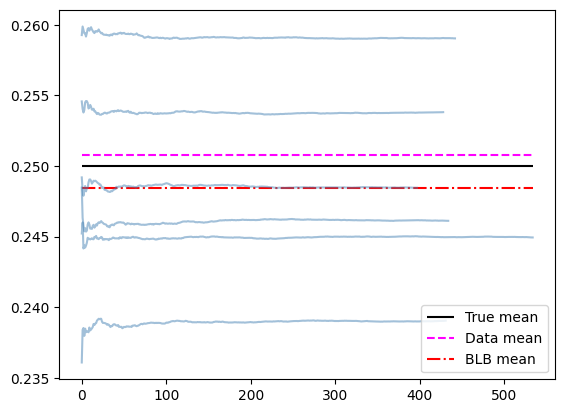

In [7]:
plt.hlines([TRUE_MEAN], xmin=0, xmax=blb_df["iter"].max(), label="True mean", color="black")
plt.hlines([mean], xmin=0, xmax=blb_df["iter"].max(), label="Data mean", color="magenta", ls="--")
plt.hlines(
    [blb_df["statistic"].mean()],
    xmin=0,
    xmax=blb_df["iter"].max(),
    color="red",
    label="BLB mean",
    ls="-.",
)
for snum, sdf in blb_df.groupby("subset"):
    plt.plot(sdf["iter"], sdf["cum_mean"], color="steelblue", alpha=0.5)
plt.legend()
plt.show()

In [8]:
blb_sdf = (
    blb_df.groupby("subset")["statistic"]
    .apply(
        lambda x: pd.Series(
            {
                "mean": x.mean(),
                "stderr": x.std(),
                "ci_lower": np.quantile(x, 0.025),
                "ci_upper": np.quantile(x, 0.975),
            }
        )
    )
    .unstack()
)
blb_sdf

,mean,stderr,ci_lower,ci_upper
subset,,,,
0,0.246118,0.001976,0.242340,0.250043
1,0.248454,0.002031,0.244547,0.252199
2,0.253811,0.001847,0.250333,0.257304
3,0.239053,0.001960,0.235347,0.242675
4,0.244940,0.001908,0.241283,0.248641
5,0.259034,0.001963,0.255048,0.262777


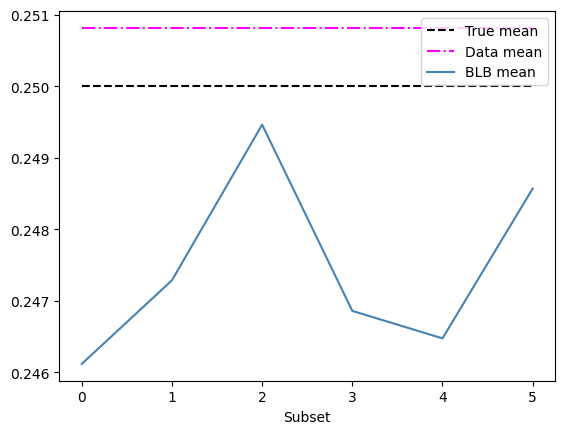

In [9]:
plt.hlines([TRUE_MEAN], xmin=0, xmax=blb_sdf.index.max(), label="True mean", color="black", ls="--")
plt.hlines([mean], xmin=0, xmax=blb_sdf.index.max(), label="Data mean", color="magenta", ls="-.")
plt.plot(
    blb_sdf.index,
    blb_sdf["mean"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
    label="BLB mean",
)
plt.xlabel("Subset")
plt.legend()
plt.show()

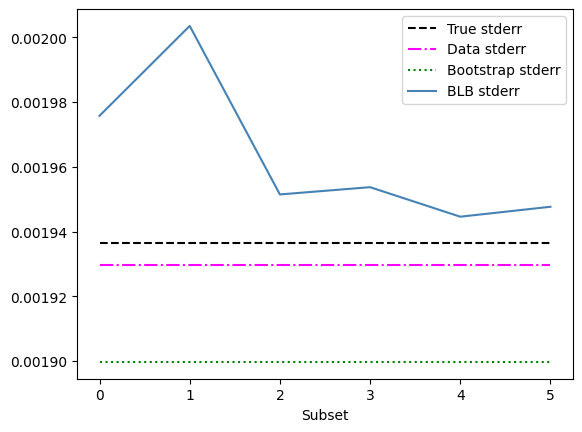

In [10]:
plt.hlines(
    [TRUE_SD / np.sqrt(N)],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="True stderr",
    color="black",
    ls="--",
)
plt.hlines([ste], xmin=0, xmax=blb_sdf.index.max(), label="Data stderr", color="magenta", ls="-.")
plt.hlines(
    [boot_res.standard_error],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="Bootstrap stderr",
    color="green",
    ls=":",
)
plt.plot(
    blb_sdf.index,
    blb_sdf["stderr"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
    label="BLB stderr",
)
plt.xlabel("Subset")
plt.legend()
plt.show()

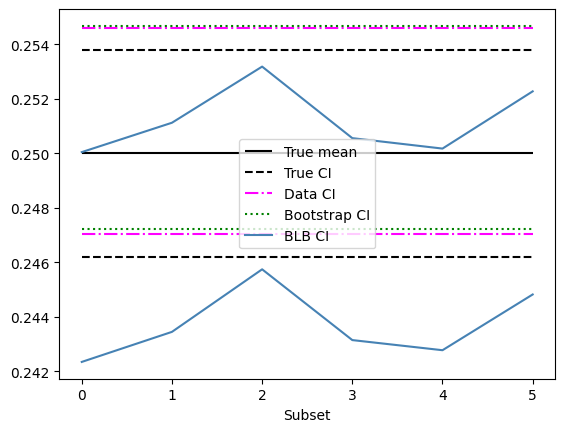

In [11]:
plt.hlines([TRUE_MEAN], xmin=0, xmax=blb_sdf.index.max(), label="True mean", color="black")
plt.hlines(
    [TRUE_MEAN - 1.96 * TRUE_SD / np.sqrt(N), TRUE_MEAN + 1.96 * TRUE_SD / np.sqrt(N)],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="True CI",
    color="black",
    ls="--",
)
plt.hlines(
    [mean - 1.96 * ste, mean + 1.96 * ste],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="Data CI",
    color="magenta",
    ls="-.",
)
plt.hlines(
    [boot_res.confidence_interval.low, boot_res.confidence_interval.high],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="Bootstrap CI",
    color="green",
    ls=":",
)
plt.plot(
    blb_sdf.index,
    blb_sdf["ci_lower"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
    label="BLB CI",
)
plt.plot(
    blb_sdf.index,
    blb_sdf["ci_upper"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
)
plt.xlabel("Subset")
plt.legend()
plt.show()

## Randomized Testing

Now let's test a bunch of possible values.

In [25]:
M = 100
N = 10_000
means = rng.beta(1, 3, size=M)
stds = rng.standard_exponential(size=M) + 0.1

data = rng.normal(
    np.broadcast_to(means.reshape((M, 1)), (M, N)), np.broadcast_to(stds.reshape((M, 1)), (M, N))
)
data.shape

(100, 10000)

In [26]:
data_means = np.mean(data, axis=1)
data_stds = np.std(data, axis=1)
param_stats = pd.DataFrame(
    {
        "rep_mean": data_means,
        "rep_var": (data_stds * data_stds) / N,
        "ci_lower": data_means - 1.96 * (data_stds / np.sqrt(N)),
        "ci_upper": data_means - 1.96 * (data_stds / np.sqrt(N)),
    }
)

In [27]:
# boots = [bootstrap([data[i, :]], np.mean, n_resamples=5000) for i in range(M)]
# boot_stats = pd.DataFrame.from_records(
#     {
#         "mean": np.mean(data[i, :]),
#         "ci_lower": boot.confidence_interval.low,
#         "ci_upper": boot.confidence_interval.high,
#     }
#     for i, boot in enumerate(boots)
# )
# boot_stats

In [28]:
blbs = [blb_summary(data[i, :], "mean", rel_tol=0.05) for i in range(M)]
blb_stats = pd.DataFrame.from_records(blbs)
blb_stats

,estimate,rep_mean,rep_var,ci_lower,ci_upper
0,0.155556,0.160216,0.000001,0.157633,0.162040
1,0.103724,0.097968,0.000561,0.071080,0.148033
2,0.343596,0.326011,0.000313,0.290250,0.354611
3,0.075131,0.069743,0.000010,0.062466,0.073803
4,0.072633,0.073120,0.000002,0.070671,0.074739
...,...,...,...,...,...
95,0.064643,0.078466,0.000034,0.068594,0.090591
96,0.449119,0.436131,0.000041,0.428212,0.448650
97,0.156858,0.159717,0.000338,0.126830,0.194622
98,0.127299,0.121039,0.000047,0.112942,0.136177


In [29]:
comb_stats = pd.DataFrame(
    {
        "Parametric": param_stats.unstack(),
        # "Bootstrap": boot_stats.unstack(),
        "BLB": blb_stats.drop(columns=["estimate"]).unstack(),
    }
)
comb_stats.index.rename(["quantity", "samp"], inplace=True)
comb_stats["Error"] = comb_stats["BLB"] - comb_stats["Parametric"]
comb_stats["RelError"] = (
    np.abs(comb_stats["BLB"] - comb_stats["Parametric"]) / comb_stats["Parametric"].abs()
)
comb_stats

Parametric       BLB     Error  RelError
quantity samp                                          
rep_mean 0       0.155556  0.160216  0.004660  0.029956
         1       0.103724  0.097968 -0.005757  0.055498
         2       0.343596  0.326011 -0.017584  0.051178
         3       0.075131  0.069743 -0.005388  0.071712
         4       0.072633  0.073120  0.000487  0.006699
...                   ...       ...       ...       ...
ci_upper 95      0.052551  0.090591  0.038041  0.723889
         96      0.435598  0.448650  0.013052  0.029963
         97      0.119923  0.194622  0.074699  0.622887
         98      0.113820  0.136177  0.022357  0.196422
         99      0.529435  0.537567  0.008131  0.015359

[400 rows x 4 columns]

In [30]:
comb_stats = comb_stats.join(
    pd.Series(means, name="RealMean", index=pd.Index(np.arange(M), name="samp"))
)
comb_stats = comb_stats.join(
    pd.Series(stds, name="RealSTD", index=pd.Index(np.arange(M), name="samp"))
)
comb_stats["AbsMean"] = comb_stats["RealMean"].abs()
comb_stats.reset_index(inplace=True)
comb_stats

,quantity,samp,Parametric,BLB,Error,RelError,RealMean,RealSTD,AbsMean
0,rep_mean,0,0.155556,0.160216,0.004660,0.029956,0.154939,0.123640,0.154939
1,rep_mean,1,0.103724,0.097968,-0.005757,0.055498,0.083691,2.412370,0.083691
2,rep_mean,2,0.343596,0.326011,-0.017584,0.051178,0.381152,1.841601,0.381152
3,rep_mean,3,0.075131,0.069743,-0.005388,0.071712,0.081031,0.337456,0.081031
4,rep_mean,4,0.072633,0.073120,0.000487,0.006699,0.072287,0.121747,0.072287
...,...,...,...,...,...,...,...,...,...
395,ci_upper,95,0.052551,0.090591,0.038041,0.723889,0.071423,0.622047,0.071423
396,ci_upper,96,0.435598,0.448650,0.013052,0.029963,0.454315,0.693925,0.454315
397,ci_upper,97,0.119923,0.194622,0.074699,0.622887,0.171009,1.900373,0.171009
398,ci_upper,98,0.113820,0.136177,0.022357,0.196422,0.128295,0.687364,0.128295


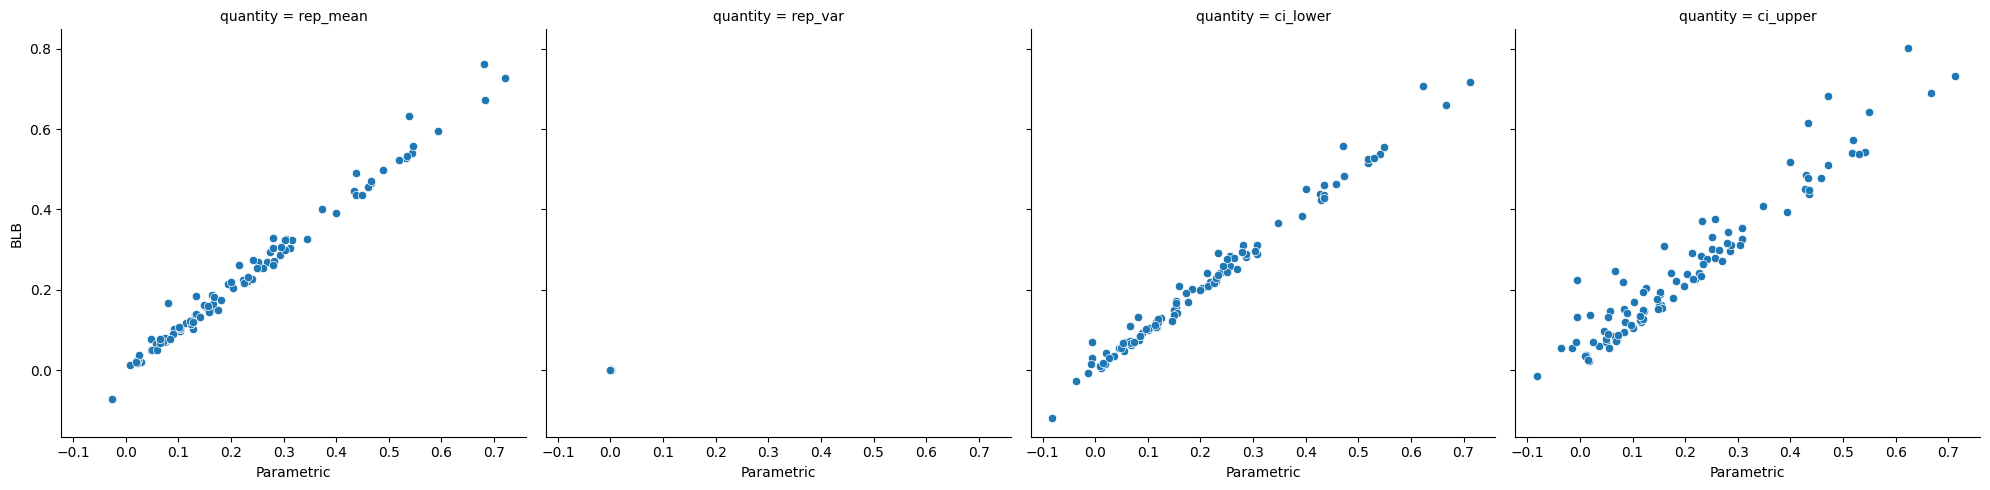

In [31]:
sns.relplot(comb_stats, x="Parametric", y="BLB", col="quantity", kind="scatter")
plt.show()

In [19]:
# sns.relplot(comb_stats, x="Bootstrap", y="BLB", col="quantity", kind="scatter")
# plt.show()

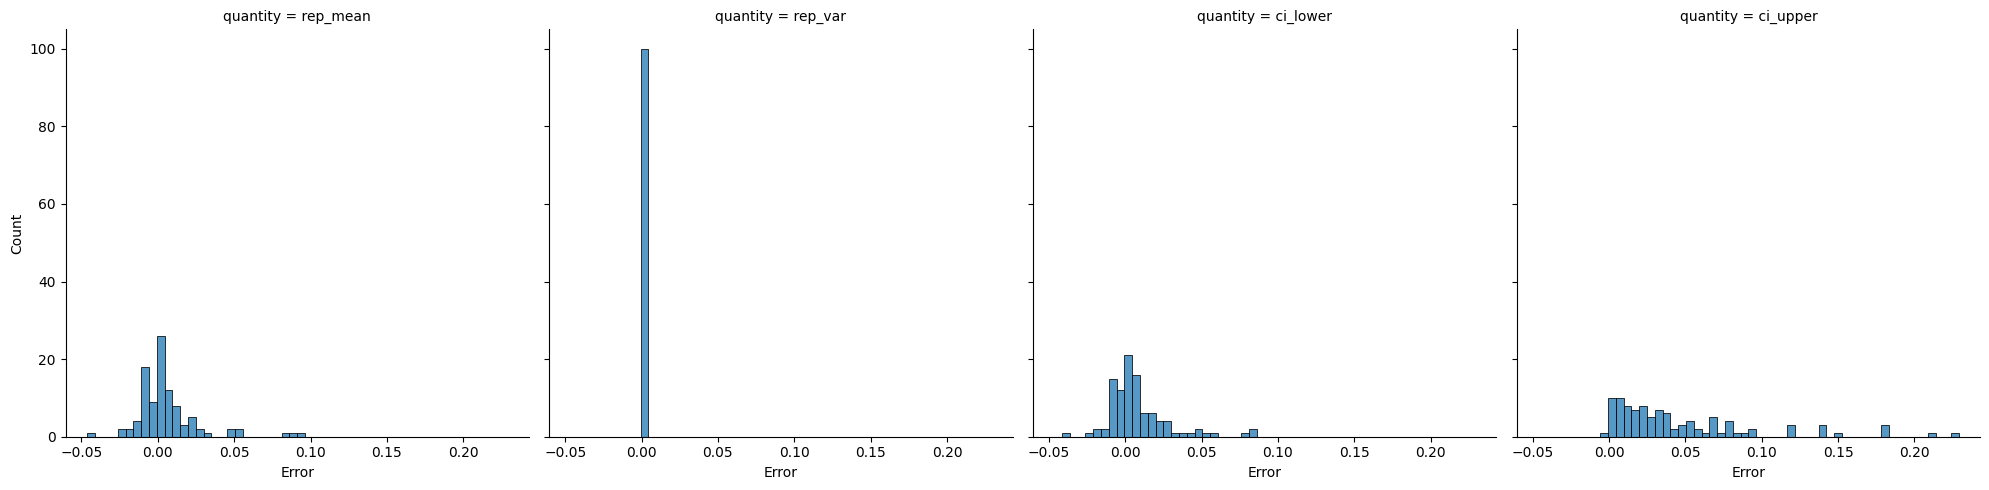

In [33]:
sns.displot(comb_stats, x="Error", col="quantity")

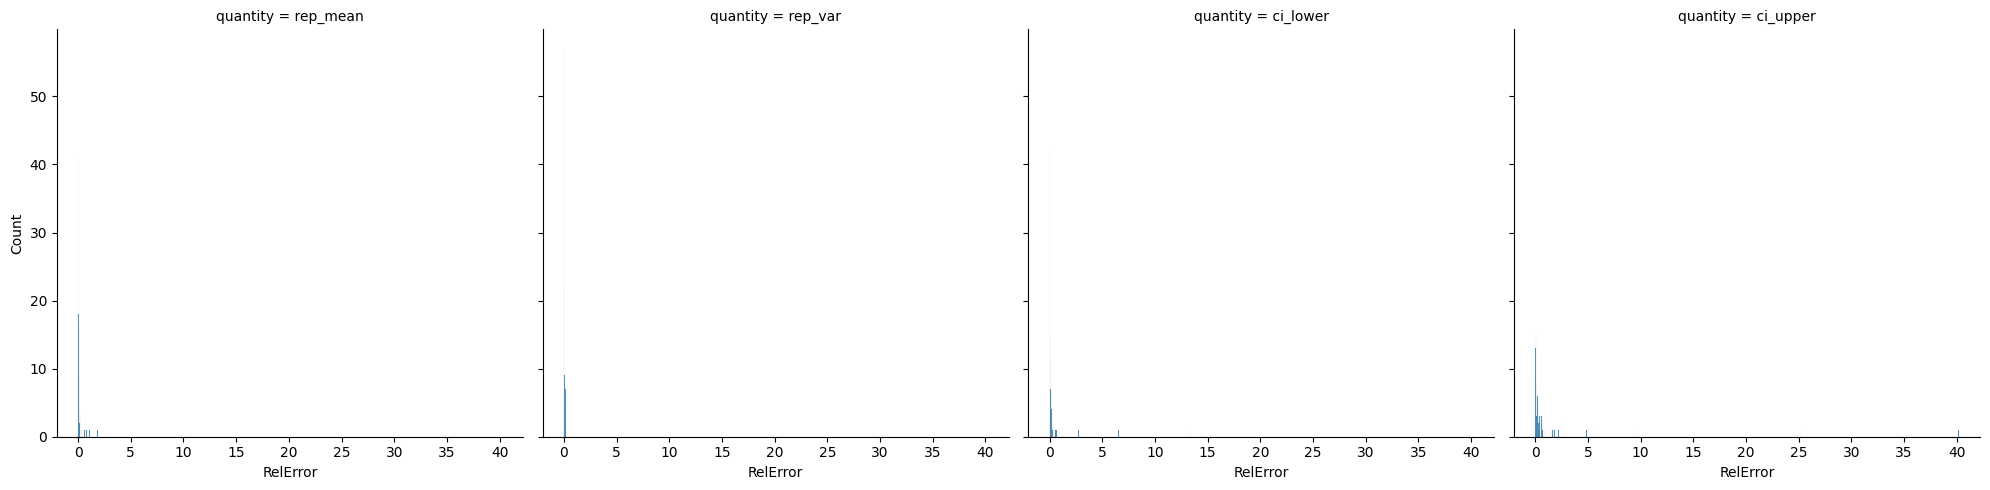

In [34]:
sns.displot(comb_stats, x="RelError", col="quantity")

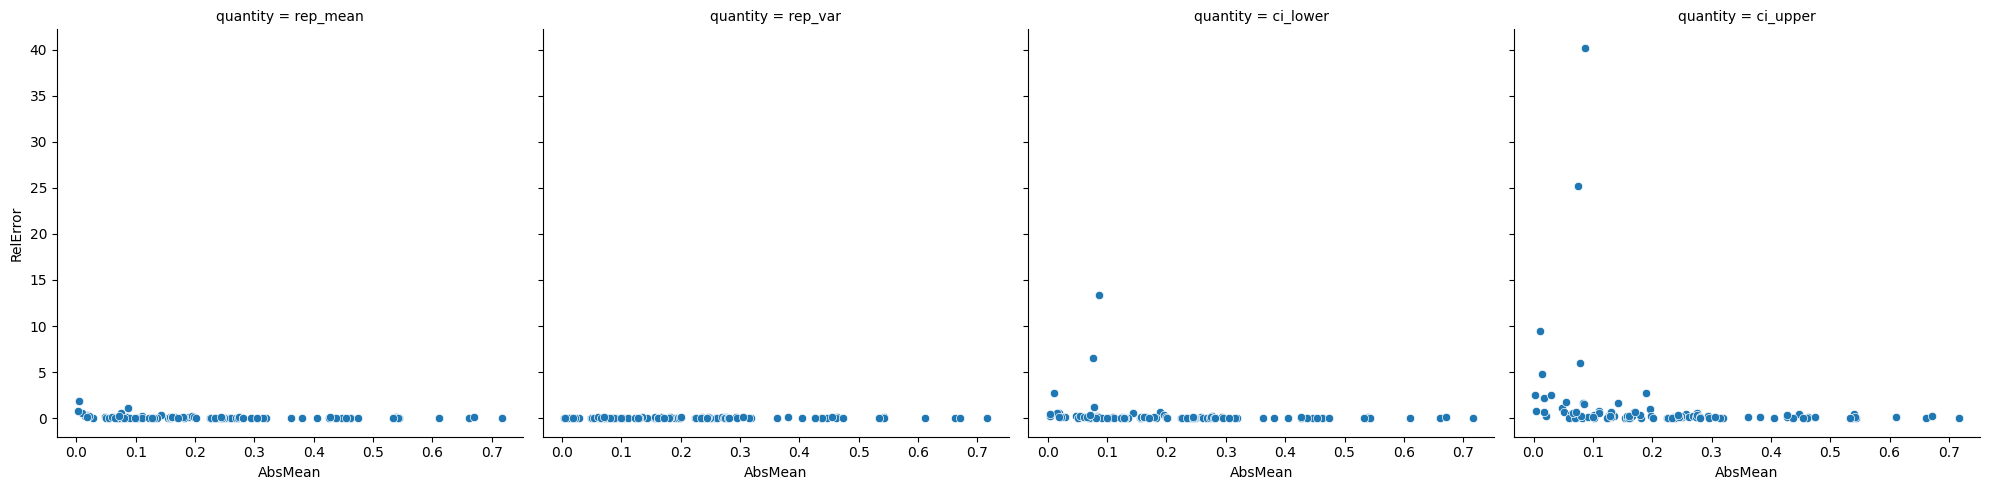

In [35]:
sns.relplot(comb_stats, x="AbsMean", y="RelError", col="quantity", kind="scatter")

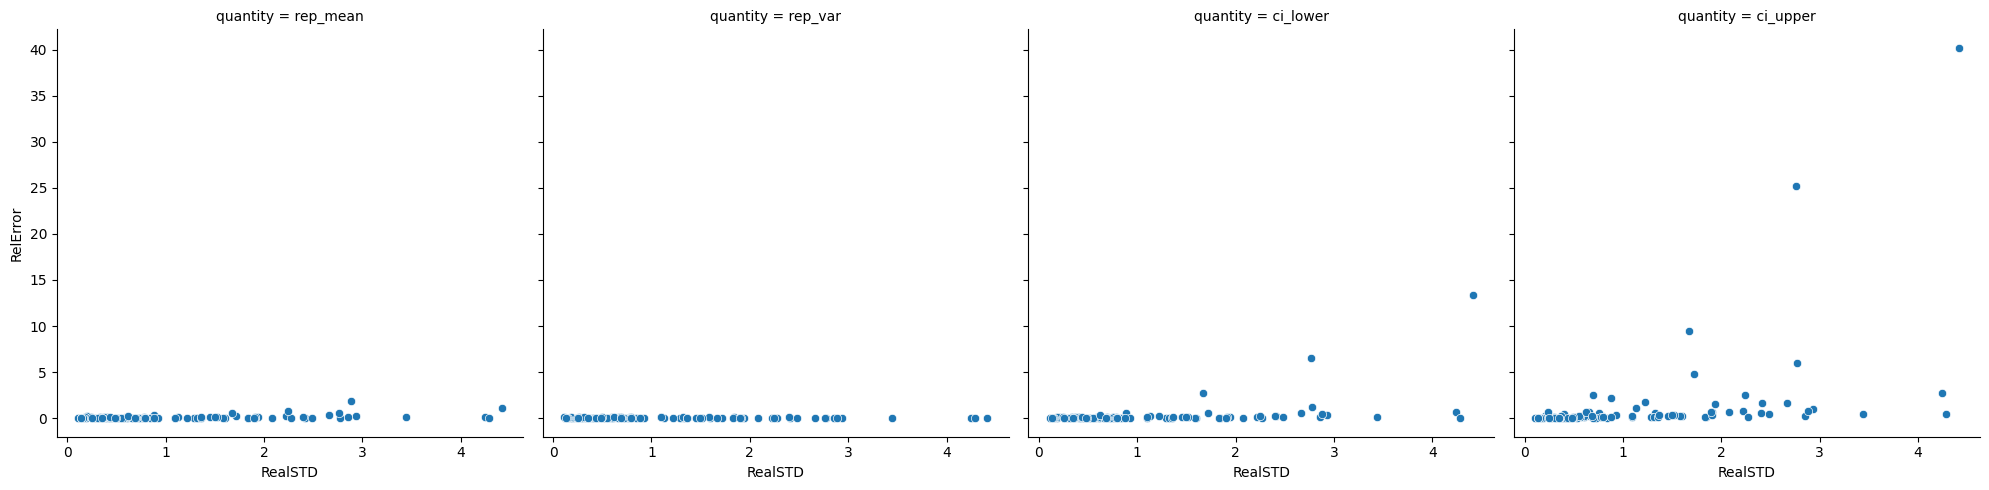

In [36]:
sns.relplot(comb_stats, x="RealSTD", y="RelError", col="quantity", kind="scatter")